In [1]:
import os, sys, logging
from datetime import datetime
import tensorflow as tf
  
# ---------- Add project root to path ----------
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv(), verbose=True) # Example:  AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")
sys.path.append(PROJECT_ROOT)
# ----------------------------------------------

from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = os.path.join(PROJECT_ROOT, r'data/03_processed/daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 32,
        'shuffle_buffer_size' : 5600, # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'epochs' : 10,
        'optimizer': tf.keras.optimizers.Adam(),
        'loss': tf.keras.losses.Huber(),
    },
    'plots': {
        'loss_zoom': 0.9,
        'show': True,
    },
}

2023-09-30 23:11:21.201767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 23:11:21.260797: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 23:11:21.262031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 23:11:22.464094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-30 23:11:25.130704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 23:11:25.165751: W tensorflow/core/common_r

In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

df_train_X = df_train.drop(columns=['Adj Close'])
df_train_y = df_train['Adj Close']

df_test_X = df_test.drop(columns=['Adj Close'])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test['Adj Close']


train_dataset_X, scalers_X = TFDataPrep.windowed_dataset_X(df_train_X, 
                                                            window_size=config['model']['window'], 
                                                            logger=logger,
                                                            verbose=False)
train_dataset_y = TFDataPrep.windowed_dataset_y(df_train_y, 
                                    window_size=config['model']['window'], 
                                    logger=logger,
                                    verbose=False)
train_dataset = TFDataPrep.combine_datasets(train_dataset_X, train_dataset_y, config, logger, verbose=False)

2023-09-30 23:11:25 - src.data.get_data - INFO - Loaded "../p7-trading-bot/data/03_processed/daily_full/MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"
2023-09-30 23:11:25 - __main__ - INFO - df.shape: (5994, 3)
2023-09-30 23:11:25 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-09-30 23:11:25 - __main__ - INFO - df_train.shape: (5695, 3), df_test.shape: (299, 3)


In [3]:
# # -----------------------------Model Architecture--------------------------
# model = tf.keras.models.Sequential([
#         tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None,2)),
#         tf.keras.layers.LSTM(32),
#         tf.keras.layers.Dense(128, activation="relu"),
#         tf.keras.layers.Dense(64, activation="relu"),
#         tf.keras.layers.Dense(1),
#         ],
#     name=config['model']['name'])

# model._name = f"{model._name}_{str(model.count_params())}_{datetime.now().strftime('%Y-%m-%d--%H-%M')}"
# log_model_info(config, model, logger)


# # -----------------------------Model Training-------------------------------
# model.compile(loss=config['model']['loss'], 
#             optimizer=config['model']['optimizer'], 
#             metrics=["mae"],
#             )    

# history = model.fit(train_dataset, epochs=config['model']['epochs'])

# # Plot MAE and Loss
# mae=history.history['mae']
# loss=history.history['loss']
# zoom = int(len(mae) * config['plots']['loss_zoom'])

# V.plot_series(x=range(config['model']['epochs'])[-zoom:],
#                 y=(mae[-zoom:],loss[-zoom:]),
#                 model_name=config['model']['name'],
#                 title='MAE_and_Loss',
#                 xlabel='MAE',
#                 ylabel='Loss',
#                 legend=['MAE', 'Loss'],
#                 show=config['plots']['show'],
#             )

In [8]:
# Save the model
# TFModelService.save_model(model=model, logger=logger)    
# TFModelService.save_scalers(scalers=scalers_X, model_name=model._name ,logger=logger)


#------------------------Load the model if necessary--------------------------
model_skaler_name = 'LSTM_42113_2023-09-30--22-01'
model = TFModelService.load_model(model_name=model_skaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_skaler_name, logger=logger)

/home/folongton/PyProjects/p7-trading-bot/models_trained/keep/LSTM_42113_2023-09-30--22-01.keras


ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm_1/lstm_cell/kernel:0', 'lstm_1/lstm_cell/recurrent_kernel:0', 'lstm_1/lstm_cell/bias:0']

2023-09-30 23:11:26 - src.models_service.models_service - INFO - ---------------------------------X_df shape-------------------------------------
2023-09-30 23:11:26 - src.models_service.models_service - INFO - X_df.shape: (299, 2)
2023-09-30 23:11:26 - src.models_service.models_service - INFO -              Adj Close      Volume
Date                              
2022-06-22  250.778474  29928297.0
2022-06-23  250.175593  25961215.0
2023-09-30 23:11:26 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-09-30 23:11:26 - src.models_service.models_service - INFO - ---------------------------------X shape-------------------------------------
2023-09-30 23:11:26 - src.models_service.models_service - INFO - X.shape: (299, 2)
2023-09-30 23:11:26 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-

280/280 [==============================] - 3s 7ms/step


2023-09-30 23:11:29 - src.models_service.models_service - INFO - ------------------------forecast for 2 first ---------------------------
2023-09-30 23:11:29 - src.models_service.models_service - INFO - (Prediction 0 - [254.63446])
2023-09-30 23:11:29 - src.models_service.models_service - INFO - (Prediction 1 - [255.28618])
2023-09-30 23:11:29 - src.models_service.models_service - INFO - Predicted shape: (280, 1)
2023-09-30 23:11:29 - src.models_service.models_service - INFO - ----------------------------------------------------------------------------------------------------
2023-09-30 23:11:29 - src.common.plots - INFO - Plot "LSTM-Predictions-2023-09-30_23-11-29-6.png" saved to "/home/folongton/PyProjects/p7-trading-bot/figures/LSTM-Predictions-2023-09-30_23-11-29-6.png"


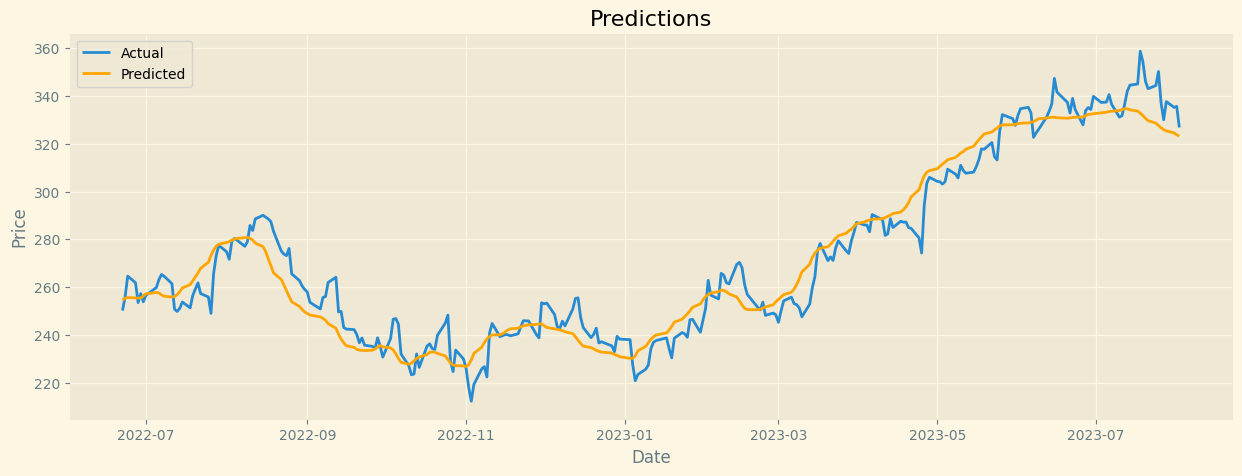

In [5]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=config['model']['window'],
                                        scalers=scalers_X,
                                        verbose=False)

df_test_plot_y = TFModelService.prep_test_df_shape(df_test_y, config)

V.plot_series(  x=df_test_plot_y.index,  # as dates
                y=(df_test_plot_y, results),
                model_name=config['model']['name'],
                title='Predictions',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=config['plots']['show'],)

In [6]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot_y.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot_y, results, naive_forecast)
ErrorCalc.save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-09-30 23:11:30 - src.models_service.errors - INFO - Test RMSE: $ 8.741
2023-09-30 23:11:30 - src.models_service.errors - INFO - Test MAE : $ 6.987
2023-09-30 23:11:30 - src.models_service.errors - INFO - Test MAPE:   0.026
2023-09-30 23:11:30 - src.models_service.errors - INFO - Test MASE:   1.731
2023-09-30 23:11:30 - src.models_service.errors - INFO - Errors saved to for LSTM model to "logs/models_table.csv" file.
